In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
def load_and_process_image(image_path, img_size=400):
    img = cv2.imread(image_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (img_size, img_size))  # Resize image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = vgg19.preprocess_input(img)  # Normalize image for VGG19
    return tf.convert_to_tensor(img, dtype=tf.float32)


In [ ]:
def deprocess_image(img_tensor):
    img = img_tensor.numpy().squeeze()  # Remove batch dimension
    img[:, :, 0] += 103.939  # Reverse mean subtraction (VGG19 normalization)
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = np.clip(img[:, :, ::-1], 0, 255).astype('uint8')  # Convert BGR to RGB
    return img


In [ ]:
def get_model():
    vgg = vgg19.VGG19(weights='imagenet', include_top=False)  # Load VGG19 without the top layers
    vgg.trainable = False  # Freeze the model

    content_layers = ['block4_conv2']  # Content layer
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']  # Style layers

    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]  # Extract features
    return Model(inputs=vgg.input, outputs=outputs), style_layers, content_layers


In [ ]:
def compute_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))


In [ ]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])  # Flatten feature map
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True) / tf.cast(n, tf.float32)  # Compute Gram matrix
    return gram


In [ ]:
def compute_style_loss(base_style, target_style):
    return tf.reduce_mean(tf.square(gram_matrix(base_style) - gram_matrix(target_style)))


In [ ]:
def total_variation_loss(image):
    x_var = image[:, :-1, :-1, :] - image[:, :-1, 1:, :]
    y_var = image[:, :-1, :-1, :] - image[:, 1:, :-1, :]
    return tf.reduce_sum(tf.abs(x_var)) + tf.reduce_sum(tf.abs(y_var))


In [ ]:
def train_style_transfer(content_path, style_path, iterations=100, alpha=1e4, beta=1e-2, tv_weight=30):
    content_img = load_and_process_image(content_path)
    style_img = load_and_process_image(style_path)
    generated_img = tf.Variable(content_img, dtype=tf.float32)  # Start with the content image

    model, style_layers, content_layers = get_model()  # Load VGG19 model
    optimizer = Adam(learning_rate=1.0)  # Adam optimizer

    content_target = model(content_img)[-1]  # Extract content features
    style_targets = model(style_img)[:-1]  # Extract style features

    for i in range(iterations):
        with tf.GradientTape() as tape:
            outputs = model(generated_img)  # Compute features of generated image
            content_loss = compute_content_loss(outputs[-1], content_target)  # Compute content loss
            style_loss = tf.add_n([compute_style_loss(outputs[i], style_targets[i]) for i in range(len(style_layers))])  # Compute style loss
            tv_loss = total_variation_loss(generated_img)  # Compute total variation loss
            total_loss = alpha * content_loss + beta * style_loss + tv_weight * tv_loss  # Total loss

        gradients = tape.gradient(total_loss, generated_img)  # Compute gradients
        optimizer.apply_gradients([(gradients, generated_img)])  # Update image

        if i % 100 == 0:
            print(f"Iteration {i}: Loss = {total_loss.numpy()}")
            output_image = deprocess_image(generated_img)
            plt.imshow(output_image)
            plt.axis('off')
            plt.show()

    return deprocess_image(generated_img)


Iteration 0: Loss = 1583437312.0


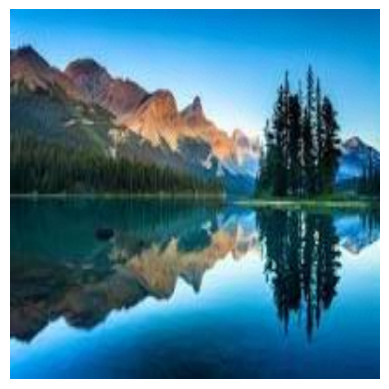

True

In [ ]:
content_image_path = 'content.jpg'  # Replace with your content image
style_image_path = 'style.jpg'      # Replace with your style image

output = train_style_transfer(content_image_path, style_image_path)
cv2.imwrite('styled_image.jpg', cv2.cvtColor(output, cv2.COLOR_RGB2BGR))  # Save the final output
